<a href="https://colab.research.google.com/github/rulogar1234/nuclio-1/blob/develop/SUP_ML_2_Modelv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SUP ML 2 - MODEL

# Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn import set_config

pd.set_option('display.max_columns',None)

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os
if sklearn.__version__ != "1.2.2":
    os.system("pip install scikit-learn==1.2.2")
print("Versión de scikit-learn:", sklearn.__version__)


Versión de scikit-learn: 1.2.2


# Carga clean data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
fichero_pickle_='/content/drive/MyDrive/Colab Notebooks/TEMPLATE SUP ML (main)/EJERCICIO-ML-SUP/data/churn_processed_train_data.pkl'

In [ ]:
import pickle
df_t= pd.read_pickle(fichero_pickle_)

In [ ]:
df_t.shape

(89999, 89)

In [ ]:
#para que las salidas sean dataframes
set_config(transform_output = "pandas")

# Split X-y

In [ ]:
#definimos el target
target = df_t.filter(like='churn').columns.tolist()[0]
features = df_t.columns[df_t.columns!=target]

# Divide dataset en matriz de variables (X) y output (y)
X = df_t[features]
y = df_t[target]

# Distribución del target

[]

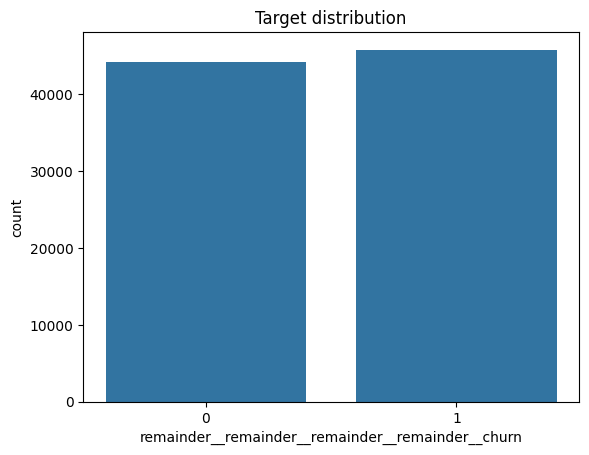

In [ ]:
sns.countplot(data=df_t,x=target)
plt.title('Target distribution')
plt.plot()

# Undersampling (*)

**NOTA:** SOLO EN CLASIFICACIÓN cuando el ratio de éxitos está MUY DESBALANCEADO (<10%).

In [ ]:
#Vamos a mirar de el train cuantos positivos y negativos  hay respecto a la muestra total
positivos=df_t[df_t[target]==1]
negativos=df_t[df_t[target]==0]

In [ ]:
#El ratio de éxitos es prácticamente igual al de fracasos (3% de diferencia), la muestra está balanceada, no hace fata hacer undersampling
(len(positivos)/len(negativos)-1)*100

3.6222538971469875

# Split TRAIN-TEST

In [ ]:
test_rate = 0.2
total_rows = len(y)
test_size = int(test_rate*total_rows)
train_size = total_rows - test_size

print('TRAIN-VALIDA: %d (%.1f%%)' %(train_size,(100-test_rate*100)))
print('TEST: %d (%.1f%%)' %(test_size,(test_rate*100)))

TRAIN-VALIDA: 72000 (80.0%)
TEST: 17999 (20.0%)


In [ ]:
#Como so sabemos si el dataset está ordenado de manera aleatoria, le damos un "meneo" y volvemos a dividir la matriz,
# creamos un dataset más pequeño para probar los arboles de decisión que tarden más
df_t2 = df_t.sample(frac=1, random_state=42)

# Divide dataset en matriz de variables (X) y output (y)
X = df_t2[features]
y = df_t2[target]

In [ ]:
X.head(3)

,kids__kids__kids__kids,remainder__hnd_web_cap__hnd_webcap__col_mas__hnd_webcap_UNKW,remainder__hnd_web_cap__hnd_webcap__col_mas__hnd_webcap_WC,remainder__hnd_web_cap__hnd_webcap__col_mas__hnd_webcap_WCMB,remainder__prizm_social_one__prizm_social_one__col_1__prizm_social_one_C,remainder__prizm_social_one__prizm_social_one__col_1__prizm_social_one_R,remainder__prizm_social_one__prizm_social_one__col_1__prizm_social_one_S,remainder__prizm_social_one__prizm_social_one__col_1__prizm_social_one_T,remainder__prizm_social_one__prizm_social_one__col_1__prizm_social_one_U,remainder__marital__marital__col_1__marital_A,remainder__marital__marital__col_1__marital_B,remainder__marital__marital__col_1__marital_M,remainder__marital__marital__col_1__marital_S,remainder__marital__marital__col_1__marital_U,remainder__remainder__crclscod__remainder__crclscod,remainder__remainder__asl_flag__remainder__asl_flag,remainder__remainder__refurb_new__remainder__refurb_new,remainder__remainder__area__col_mas__area_ATLANTIC SOUTH AREA,remainder__remainder__area__col_mas__area_CALIFORNIA NORTH AREA,remainder__remainder__area__col_mas__area_CENTRAL/SOUTH TEXAS AREA,remainder__remainder__area__col_mas__area_CHICAGO AREA,remainder__remainder__area__col_mas__area_DALLAS AREA,remainder__remainder__area__col_mas__area_DC/MARYLAND/VIRGINIA AREA,remainder__remainder__area__col_mas__area_GREAT LAKES AREA,remainder__remainder__area__col_mas__area_HOUSTON AREA,remainder__remainder__area__col_mas__area_LOS ANGELES AREA,remainder__remainder__area__col_mas__area_MIDWEST AREA,remainder__remainder__area__col_mas__area_NEW ENGLAND AREA,remainder__remainder__area__col_mas__area_NEW YORK CITY AREA,remainder__remainder__area__col_mas__area_NORTH FLORIDA AREA,remainder__remainder__area__col_mas__area_NORTHWEST/ROCKY MOUNTAIN AREA,remainder__remainder__area__col_mas__area_OHIO AREA,remainder__remainder__area__col_mas__area_PHILADELPHIA AREA,remainder__remainder__area__col_mas__area_SOUTH FLORIDA AREA,remainder__remainder__area__col_mas__area_SOUTHWEST AREA,remainder__remainder__area__col_mas__area_TENNESSEE AREA,remainder__remainder__new_cell__remainder__new_cell_N,remainder__remainder__new_cell__remainder__new_cell_U,remainder__remainder__new_cell__remainder__new_cell_Y,remainder__remainder__creditcd__col_1__creditcd_N,remainder__remainder__remainder__col_num__mou,remainder__remainder__remainder__col_num__change_mou,remainder__remainder__remainder__hnd_price__hnd_price,remainder__remainder__remainder__income__income,remainder__remainder__remainder__eqpdays__eqpdays,remainder__remainder__remainder__remainder__drop_vce,remainder__remainder__remainder__remainder__drop_dat,remainder__remainder__remainder__remainder__blck_vce,remainder__remainder__remainder__remainder__blck_dat,remainder__remainder__remainder__remainder__unan_vce,remainder__remainder__remainder__remainder__unan_dat,remainder__remainder__remainder__remainder__plcd_dat,remainder__remainder__remainder__remainder__recv_vce,remainder__remainder__remainder__remainder__recv_sms,remainder__remainder__remainder__remainder__custcare,remainder__remainder__remainder__remainder__ccrndmou,remainder__remainder__remainder__remainder__threeway,remainder__remainder__remainder__remainder__mou_cvce,remainder__remainder__remainder__remainder__mou_cdat,remainder__remainder__remainder__remainder__mou_rvce,remainder__remainder__remainder__remainder__owylis_vce,remainder__remainder__remainder__remainder__mouowylisv,remainder__remainder__remainder__remainder__iwylis_vce,remainder__remainder__remainder__remainder__mouiwylisv,remainder__remainder__remainder__remainder__peak_vce,remainder__remainder__remainder__remainder__peak_dat,remainder__remainder__remainder__remainder__mou_peav,remainder__remainder__remainder__remainder__mou_pead,remainder__remainder__remainder__remainder__opk_vce,remainder__remainder__remainder__remainder__opk_dat,remainder__remainder__remainder__remainder__mou_opkv,remainder__remainder__remainder__remainder__drop_blk,re

In [ ]:
y.head(3)

Customer_ID
1054760    1
1012457    1
1053402    1
Name: remainder__remainder__remainder__remainder__churn, dtype: int64

In [ ]:
#dividimos
X_train = X.head(train_size)
y_train = y.head(train_size)
X_test = X.tail(test_size)
y_test = y.tail(test_size)

# Rescaling

* NO NECESARIO en modelos de Arboles de Decisión.
* Guardar scaler en el model path.

In [ ]:
from sklearn.preprocessing import StandardScaler
# Estandarización: fit_transform() en train, transform() en test, estandard scaling se usa cuando los datos no sean tan sensibles a outlayers
scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)

X_train_std = pd.DataFrame(X_train_std, columns = X_train.columns, index= X_train.index)


# TRAIN-VALIDA

## Torneo de Modelos

* Probamos una colección de modelos con el objetivo de conseguir el mejor rendimiento del modelo en los datos de VALIDACION.

In [ ]:
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Funcion que calcula el AUC de un modelo sobre un dataset (X-y). Args: modelo a validar, X, y
def auc(model,X,y):
  model.fit(X,y)
  return roc_auc_score(y,model.predict_proba(X)[:,1])

# Funcion que calcula el AUC en Cross-Validation (X-y). Args: modelo a validar, X, y
def auc_cross_validation(model,X,y):
  cross_val = cross_val_score(model,
                              X, y,
                              cv=4,                 # Numero de folds que vamos a utilizar para validar
                              scoring='roc_auc'     # La metrica de validacion que se medira en cada train-valida
                              )
  return cross_val.mean()

In [ ]:
# Inicializa resultados
label_, auc_train_ , auc_valida_ = [], [], []

# Completa un registro en dataframe con los resultados de las funciones definidas previsamente ( AUC y AUC con cross-validation)

# Inputs:
#   * modelo
#   * (X,y)
#   * label especifico si queremos registrar el resultado con otro nombre (opcional)


def evaluate_classification(model, X, y, label=None):
  if label is None:
    label=str(model)
  label_.append(label)

  auc_train = auc(model,X,y)
  auc_valida = auc_cross_validation(model,X,y)
  auc_train_.append(auc_train)
  auc_valida_.append(auc_valida)

  return pd.DataFrame({'Model': label_,
                      'AUC Train': auc_train_,
                      'AUC Cross-Valida': auc_valida_
                      }).sort_values('AUC Cross-Valida',ascending=False)

In [ ]:
#Vamos a hacer una primera barrida de modelos con una muestra más pequeña para orientarnos en los más eficientes sin tener que esperar tanto, primero lo hacemos con datos de entrenamiento estadarizado
X_train_std_s=X_train_std.head(5000)
X_train_s=X_train.head(5000)
y_train_s=y_train.head(5000)


In [ ]:
'''modelos=[DecisionTreeClassifier(),RandomForestClassifier(),XGBClassifier(),LGBMClassifier(),KNeighborsClassifier(),GradientBoostingClassifier(),MLPClassifier(),ExtraTreesClassifier()]
label_.clear()
auc_train_.clear()
auc_valida_.clear()
for i in modelos:
  model=i
  model.fit(X_train_std_s, y_train_s)
  modelcomp=evaluate_classification(model, X_train_std_s,y_train_s)
modelcomp'''

'modelos=[DecisionTreeClassifier(),RandomForestClassifier(),XGBClassifier(),LGBMClassifier(),KNeighborsClassifier(),GradientBoostingClassifier(),MLPClassifier(),ExtraTreesClassifier()]\nlabel_.clear()\nauc_train_.clear()\nauc_valida_.clear()\nfor i in modelos:\n  model=i\n  model.fit(X_train_std_s, y_train_s)\n  modelcomp=evaluate_classification(model, X_train_std_s,y_train_s)\nmodelcomp'

In [ ]:
#después sin los datos estandarizados
modelos=[DecisionTreeClassifier(),RandomForestClassifier(),XGBClassifier(),LGBMClassifier(),KNeighborsClassifier(),GradientBoostingClassifier(),MLPClassifier(),ExtraTreesClassifier()]
label_.clear()
auc_train_.clear()
auc_valida_.clear()
for i in modelos:
  model=i
  model.fit(X_train_s, y_train_s)
  modelcomp=evaluate_classification(model, X_train_s,y_train_s)
modelcomp

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2545, number of negative: 2455
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7622
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509000 -> initscore=0.036004
[LightGBM] [Info] Start training from score 0.036004
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2545, number of negative: 2455
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise

,Model,AUC Train,AUC Cross-Valida
5,GradientBoostingClassifier(),0.804459,0.624661
1,RandomForestClassifier(),1.000000,0.616100
3,LGBMClassifier(),0.987150,0.613408
2,"XGBClassifier(base_score=None, booster=None, c...",0.999840,0.601978
7,ExtraTreesClassifier(),1.000000,0.565159
0,DecisionTreeClassifier(),1.000000,0.548390
4,KNeighborsClassifier(),0.777635,0.540903
6,MLPClassifier(),0.545925,0.500635


In [ ]:
#Cogemos los 2 primeros modelos y le pasamos los datos de entrenamiento completos
'''modelos=[GradientBoostingClassifier(),RandomForestClassifier()]
label_.clear()
auc_train_.clear()
auc_valida_.clear()
for i in modelos:
  model=i
  model.fit(X_train_std, y_train)
  modelcomp=evaluate_classification(model, X_train_std, y_train)
modelcomp'''

'modelos=[GradientBoostingClassifier(),RandomForestClassifier()]\nlabel_.clear()\nauc_train_.clear()\nauc_valida_.clear()\nfor i in modelos:\n  model=i\n  model.fit(X_train_std, y_train)\n  modelcomp=evaluate_classification(model, X_train_std, y_train)\nmodelcomp'

In [ ]:
#Cogemos los 2 primeros modelos y le pasamos los datos de entrenamiento que han dado mejor puntuación en el paso anterior
'''modelos=[RandomForestClassifier(),GradientBoostingClassifier()]
label_.clear()
auc_train_.clear()
auc_valida_.clear()
for i in modelos:
  model=i
  model.fit(X_train, y_train)
  modelcomp=evaluate_classification(model, X_train,y_train)
modelcomp'''

'modelos=[RandomForestClassifier(),GradientBoostingClassifier()]\nlabel_.clear()\nauc_train_.clear()\nauc_valida_.clear()\nfor i in modelos:\n  model=i\n  model.fit(X_train, y_train)\n  modelcomp=evaluate_classification(model, X_train,y_train)\nmodelcomp'

## Hiperparametrizacion

* Utilizar RandomSearch para probar diferentes configuraciones de los parametros del modelo ganador en el torneo de modelos con el objetivo de mejorar el control del overfitting.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
param_distributions = {
    'learning_rate': [0.04],
    'max_depth': [5],  # Profundidades máximas sugeridas
    'n_estimators': [200],  # Número de árboles sugeridos
    'subsample': [0.9],  # Fracción de muestras para entrenar cada árbol
    'min_samples_split': [30],  # Número mínimo de muestras requeridas para dividir un nodo interno
    'min_samples_leaf': [10],  # Número mínimo de muestras requeridas para ser una hoja
    'max_features': ['sqrt', 'log2', 'auto']  # Número de características a considerar para la mejor división
}


In [ ]:
# Configuración de RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),  # Estimador GradientBoostingClassifier
    param_distributions=param_distributions,
    scoring='roc_auc',  # Métrica a optimizar: AUC
    cv=5,  # Número de folds para cross-validation
    n_iter=20
    #, # Número de iteraciones, cada una testeará una configuración distinta
    #n_jobs=-1,  # Utilizar todos los procesadores disponibles
    #verbose=True
)

In [ ]:
'''parametros = {
  'subsample': [1],
  'num_leaves': [50],
  'min_child_samples': [100],
  'max_depth': [10],
  'lambda_l2': [1],
  'lambda_l1': [1],
  'feature_fraction': [0.5]
}'''

In [ ]:
'''random_search = RandomizedSearchCV(estimator=LGBMClassifier(),
                               param_distributions = parametros,
                               scoring='roc_auc',
                               cv = 5,                                    # numero de folds para cross-validation
                               n_iter = 100,                               # numero de iteraciones, cada una testeara una configuracion distinta
                               n_jobs=-1,
                               error_score='raise'
                               )'''

In [ ]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=20,
                   param_distributions={'learning_rate': [0.04],
                                        'max_depth': [5],
                                        'max_features': ['sqrt', 'log2',
                                                         'auto'],
                                        'min_samples_leaf': [10],
                                        'min_samples_split': [30],
                                        'n_estimators': [200],
                                        'subsample': [0.9]},
                   scoring='roc_auc')

In [ ]:
random_search.best_estimator_

GradientBoostingClassifier(learning_rate=0.04, max_depth=5, max_features='auto',
                           min_samples_leaf=10, min_samples_split=30,
                           n_estimators=200, random_state=42, subsample=0.9)

In [ ]:
random_search.best_score_

0.6715927048014975

## Modelo final

* Entrenar el modelo final con el algoritmo y los parametros que hanfuncionado mejor en anteriores experimentos.
* Argumentar la elección.
* Guardar el modelo en model path.

In [ ]:
best_model = random_search.best_estimator_

# TEST

* Evaluación de las métricas de performance en TEST.

In [ ]:
y_train_pred = best_model.predict(X_train)              # predicciones del modelo en los datos de TRAIN
y_test_pred = best_model.predict(X_test)                # predicciones del modelo en los datos de TEST

In [ ]:
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]      # probabilidad de éxito (1) segun el modelo en los datos de TRAIN
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]        # probabilidad de éxito (1) segun el modelo en los datos de TEST

# AUC

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
auc_train = roc_auc_score(y_train, y_train_pred_proba)      # AUC en TRAIN
auc_test = roc_auc_score(y_test, y_test_pred_proba)         # AUC en TEST

In [ ]:
print('AUC Train:', round(auc_train,4))
print('AUC Test:', round(auc_test,4))

AUC Train: 0.7208
AUC Test: 0.672


# ROC Curve

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
# metrics for ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

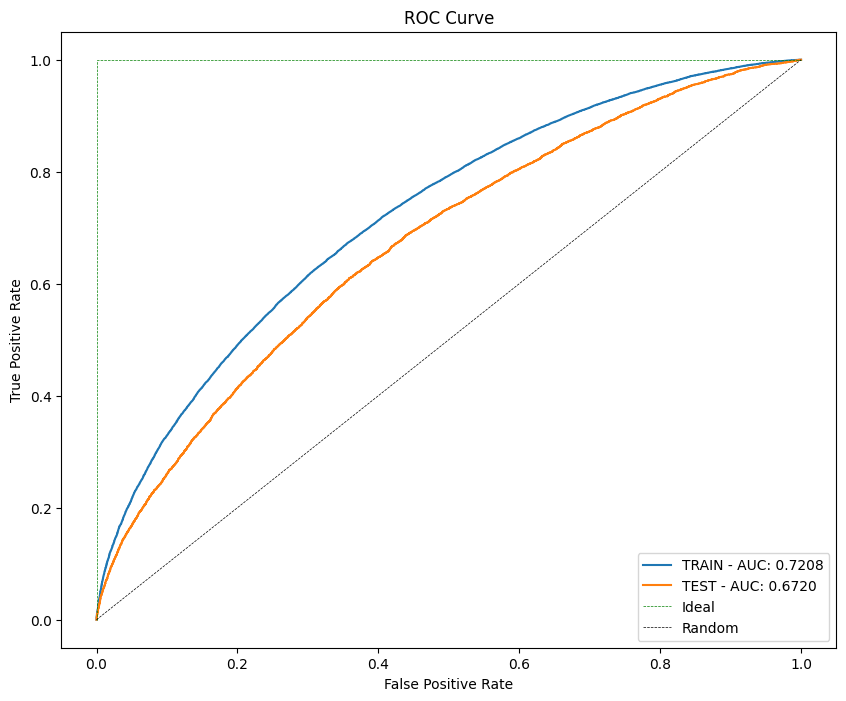

In [ ]:
#Plot
plt.figure(figsize=[10,8])
plt.plot(fpr_train, tpr_train, label='TRAIN - AUC: {:.4f}'.format(auc_train))
plt.plot(fpr_test, tpr_test, label='TEST - AUC: {:.4f}'.format(auc_test))
plt.title('ROC Curve')
plt.plot([0,0,1],[0,1,1], color='green', linestyle='--', linewidth=0.5, label='Ideal')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', linewidth=0.5, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
cm_test = confusion_matrix(y_test, y_test_pred)

[]

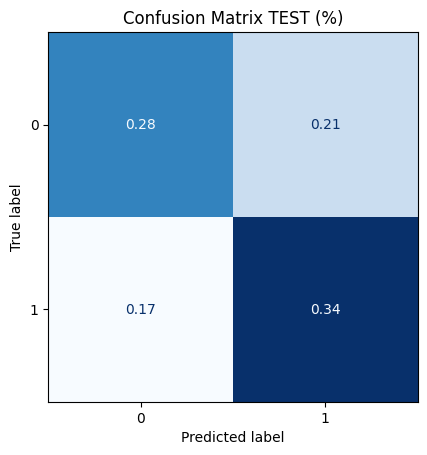

In [ ]:
ConfusionMatrixDisplay(confusion_matrix=cm_test/len(y_test)).plot(colorbar = False, cmap = 'Blues')
plt.title('Confusion Matrix TEST (%)')
plt.plot()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Accuracy:', round( accuracy_score(y_test, y_test_pred),4))
print('Precision:', round( precision_score(y_test, y_test_pred), 4))
print('Recall:', round( recall_score(y_test, y_test_pred), 4))
print('F1-score:', round(f1_score(y_test, y_test_pred), 4))

Accuracy: 0.624
Precision: 0.6208
Recall: 0.6683
F1-score: 0.6437


# INTERPRETABILITY

* Analizamos top features del modelo y su peso en el modelo.
* Plotear SHAP values y el impacto positivo/negativo.
* Comentar las top5 features, su impacto en el target y extraer insights.
* Analisis complementarios:
  * Modelos de arboles: Feature Importances, plot de arbol de decision.
  * Modelos lineales: Coeficentes y formula del modelo.

In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 3.5 MB/s eta 0:00:00


In [ ]:
import shap

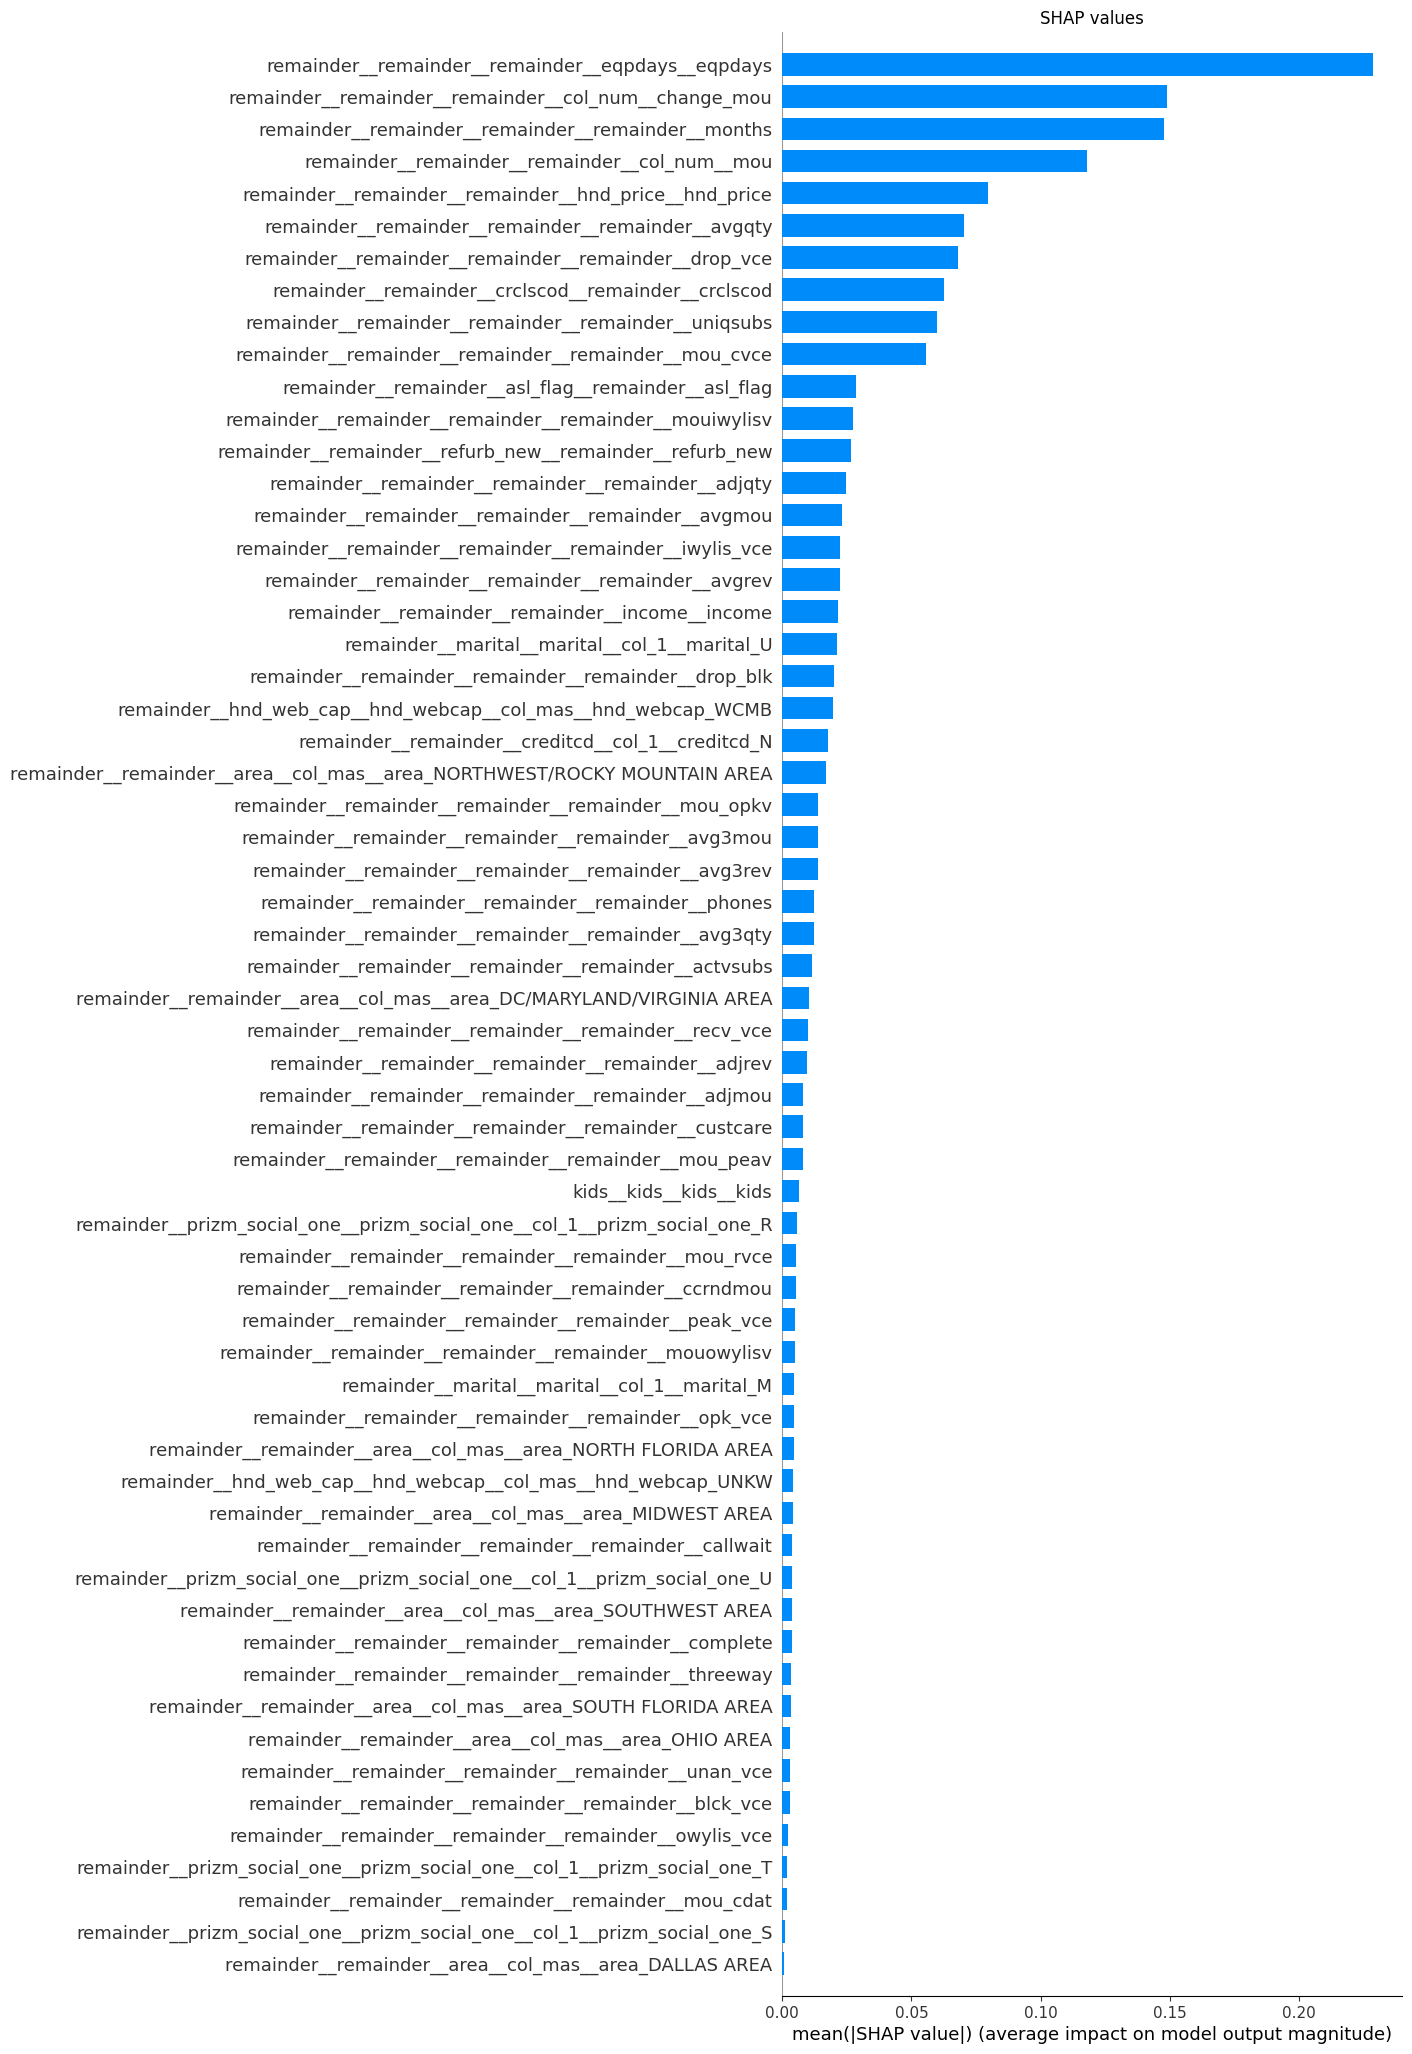

In [ ]:
#SHAP value: peso en el output final, mantenog todas las vriables estáticas y veo que pasa si aumento las unidades de esa variable.
#Así miramo el impacto que teien sobre el impacto de la previsión. Es una medida del impacto de las variables
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
plt.title('SHAP values')
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=60)

In [ ]:
#Salvamos el modelo ganador
modelo_pickle_='/content/drive/MyDrive/Colab Notebooks/TEMPLATE SUP ML (main)/EJERCICIO-ML-SUP/data/modelo_pickle.pkl'
pickle.dump(best_model, open(modelo_pickle_, 'wb'))